# Customer Feedback Sentiment Analysis (IMDB Reviews) using Machine Learning models


#### This notebook demonstrates a complete machine learning workflow for sentiment analysis on the IMDB movie reviews dataset. It covers data loading, cleaning, feature engineering, visualization, and model building using both Logistic Regression and Support Vector Machine (SVM) classifiers. The notebook includes hyperparameter tuning, evaluation metrics, and analysis of misclassified examples to help understand model performance and limitations.

## Import Libraries 

In [ ]:
# Import necessary libraries for data processing, visualisation, and modelling
import joblib
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from datasets import load_dataset


## Download NLTK Stopwords 

In [ ]:
# Download NLTK stop words and set stop words list
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shashwatpasari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load IMDB dataset 

In [ ]:
# Load IMDB sentiment dataset and convert to pandas DataFrames
ds = load_dataset("Kwaai/IMDB_Sentiment")  # train/test/unsupervised
df_test = ds["test"].to_pandas()[["text","label"]]
df_train = ds["train"].to_pandas()[["text","label"]]

/Users/shashwatpasari/Programming/Projects/projects_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inspect dataset structure 

In [ ]:
# Display DataSet Structure 
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

## Regex patterns for cleaning

In [ ]:
# Compile regex patterns for HTML tags and non-alphabetic characters
_html = re.compile(r"<.*?>")
_nonalpha = re.compile(r"[^a-zA-Z\s]+")

## Negation words for cleaning 

In [ ]:
# Set of negation words to keep during cleaning
NEG_KEEP = {"not","no","nor","n't"} # simple negation safeguard

## Text Cleaning Function 

In [ ]:
# Function to clean review text:
# 1. Remove HTML
# 2. Remove non-alpha characters
# 3. Convert to lower case
# 4. Remove stop words except negations
def clean_ml(text):
    text = _html.sub(" ", text)
    text = _nonalpha.sub(" ", text)
    text = text.lower().strip()
    toks = []
    for w in text.split():
        if (w in NEG_KEEP) or (w not in stop_words):
            toks.append(w)
    return " ".join(toks)

## Clean and add features to dataframes

In [ ]:
# Clean review text and add word length feature 
df_train["clean_text"] = df_train["text"].astype(str).apply(clean_ml)
df_train["length"] = df_train["clean_text"].str.split().apply(len)
df_test["clean_text"] = df_test["text"].astype(str).apply(clean_ml)

## Check dataset sizes 

In [ ]:
# Print the number of samples in the train and test sets
len(df_train),len(df_test)

(25000, 25000)

## Class balance visualisation

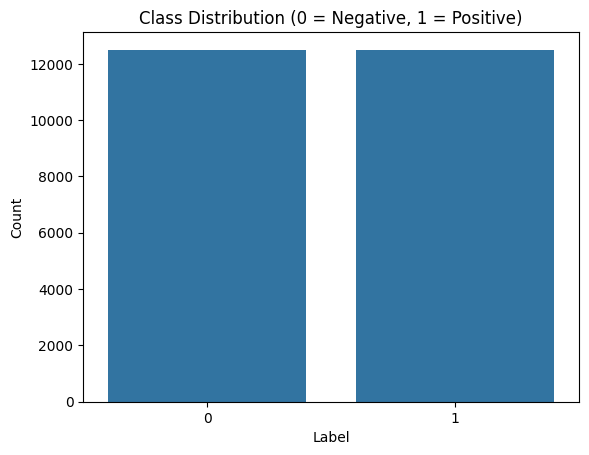

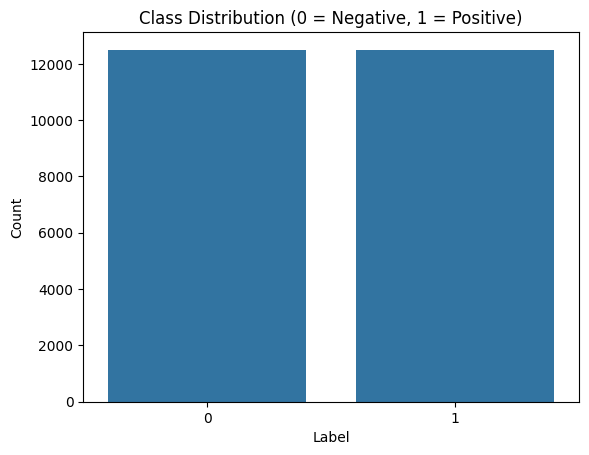

In [ ]:
# Class balance
# Plot class distribution for train and test sets
sns.countplot(x="label", data=df_train)
plt.title("Class Distribution (0 = Negative, 1 = Positive)")
plt.xlabel("Label"); plt.ylabel("Count")
plt.show()

sns.countplot(x="label", data=df_test)
plt.title("Class Distribution (0 = Negative, 1 = Positive)")
plt.xlabel("Label"); plt.ylabel("Count")
plt.show()

## Review Length Distribution 

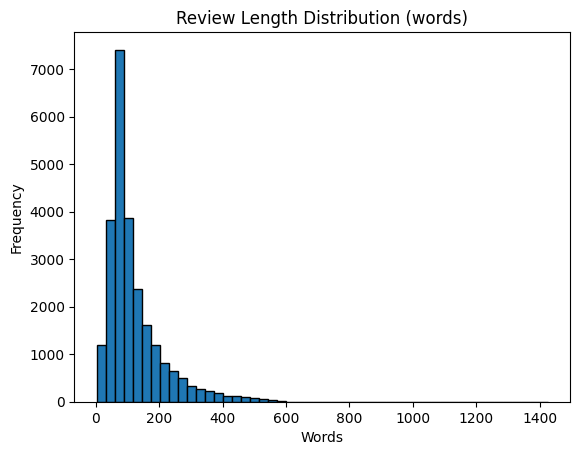

In [ ]:
# Review length distribution
# Plot histogram of review lengths 
plt.hist(df_train["length"], bins=50, edgecolor="black")
plt.title("Review Length Distribution (words)")
plt.xlabel("Words"); plt.ylabel("Frequency")
plt.show()

## Word clouds for sentiment classes

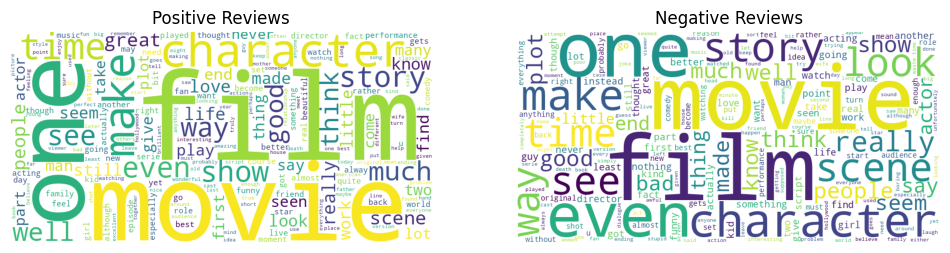

In [ ]:
# Word clouds (positive vs negative)
# Generate word clouds for positive and negative reviews
pos_text = " ".join(df_train.loc[df_train["label"]==1, "clean_text"])
neg_text = " ".join(df_train.loc[df_train["label"]==0, "clean_text"])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=800, height=400, background_color="white").generate(pos_text))
plt.axis("off"); plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=800, height=400, background_color="white").generate(neg_text))
plt.axis("off"); plt.title("Negative Reviews")
plt.show()

## Top Unigrams 

In [ ]:
# Top unigrams (quick peek)
# Print top 20 common words in clean reviews
all_words = " ".join(df_train["clean_text"]).split()
print("Top 20 unigrams:", Counter(all_words).most_common(20))

Top 20 unigrams: [('movie', 44046), ('film', 40162), ('not', 30634), ('one', 26795), ('like', 20281), ('good', 15147), ('time', 12726), ('no', 12724), ('even', 12656), ('would', 12436), ('story', 11990), ('really', 11739), ('see', 11479), ('well', 10668), ('much', 9766), ('get', 9312), ('bad', 9308), ('people', 9287), ('also', 9159), ('first', 9064)]


## Prepare train/test data for modelling

In [ ]:
# Prepare train and test data arrays for modelling
X_train_text = df_train["clean_text"].values
y_train = df_train["label"].values
X_test_text  = df_test["clean_text"].values
y_test = df_test["label"].values

## TF-IDF Vectorizer Setup 

In [ ]:
# Setup TF-IDF Vectorizer for feature extraction
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True,
    strip_accents="unicode"
)

## Transform text data with TF-IDF 

In [ ]:
# Fit TF-IDF on train data and transform test data
X_train = tfidf.fit_transform(X_train_text)
X_test  = tfidf.transform(X_test_text)

X_train.shape, X_test.shape  # sanity check

((25000, 92235), (25000, 92235))

## Logistic Regression Model and Grid Search 

In [ ]:
# Define parameter grid for logistic regression
param_grid = {
    "C": [0.1, 0.5, 1, 2, 5],             # Regularization strength
    "solver": ["liblinear", "saga"],      # Both work with binary sparse data
    "class_weight": [None, "balanced"]    # Try both balanced and unbalanced
}

# Logistic Regression base model
logreg = LogisticRegression(max_iter=500)


# GridSearch with 3-fold CV
grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring="f1", 
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid.fit(X_train, y_train)

# Best parameters & score
print("Best Parameters:", grid.best_params_)
print("Best F1 Score (CV):", grid.best_score_)

best_logreg = grid.best_estimator_
test_pred = best_logreg.predict(X_test)

print("\nTest Set Performance:\n", classification_report(y_test, test_pred, digits=4))

os.makedirs("artifacts", exist_ok=True)

# Save model and vectorizer 
joblib.dump(best_logreg, "artifacts/best_logreg.pkl")
joblib.dump(tfidf, "artifacts/tfidf.pkl")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'C': 2, 'class_weight': 'balanced', 'solver': 'saga'}
Best F1 Score (CV): 0.8751070889542287

Test Set Performance:
               precision    recall  f1-score   support

           0     0.8966    0.8978    0.8972     12500
           1     0.8977    0.8965    0.8971     12500

    accuracy                         0.8972     25000
   macro avg     0.8972    0.8972    0.8972     25000
weighted avg     0.8972    0.8972    0.8972     25000



['artifacts/tfidf.pkl']

## Logistic Regression Misclassified Examples 

In [ ]:
# Compare with true labels
misclassified_idx = (test_pred != y_test)

# Create a DataFrame of misclassified examples
errors_df = pd.DataFrame({
    "review": X_test_text[misclassified_idx],
    "clean_review": df_test["clean_text"].values[misclassified_idx],
    "true_label": y_test[misclassified_idx],
    "predicted_label": test_pred[misclassified_idx]
})

# Show first 10 misclassified reviews
pd.set_option("max_colwidth", 200)  # to see more text
print(errors_df.head(10))

# Save misclassified reviews to CSV
errors_df.to_csv("artifacts/logreg_misclassified.csv", index=False)
print("Saved misclassified reviews to artifacts/logreg_misclassified.csv")


                                                                                                                                                                                                    review  \
0  first let say enjoyed van damme movie since bloodsport probably not like movie movies may not best plots best actors enjoy kinds movies movie much better movies action guys segal dolph thought put...   
1  blind date columbia pictures decent film issues film first fault actors film less problem script also understand film made people looking escape reality script made ann sothern character look weak...   
2  ben rupert grint deeply unhappy adolescent son unhappily married parents father nicholas farrell vicar mother laura linney well let say somewhat hypocritical soldier jesus army takes summer job as...   
3  type guy loves hood movies new jack city baby boy killa season b grade hollywood movie something different no hater movie kinda enjoyable bits weird well acting good compare

## SVM Model and Grid Search 

In [ ]:
# Define parameter grid for SVM 
svm_params = {
    "C": [0.25, 0.5, 1, 2, 4] # soft-margin strength
}
# Grid search for SVM 
svm_grid = GridSearchCV(
    estimator=LinearSVC(),
    param_grid=svm_params,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=2
)

svm_grid.fit(X_train, y_train)


print("Best SVM params: ", svm_grid.best_params_)
print("Best CV F1:", svm_grid.best_score_)

best_svm = svm_grid.best_estimator_
test_pred = best_svm.predict(X_test)

print("\nTest Set Performance:\n", classification_report(y_test, test_pred, digits=4))

os.makedirs("artifacts", exist_ok=True)

# Save SVM model
joblib.dump(best_logreg, "artifacts/best_svm.pkl")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best SVM params:  {'C': 0.25}
Best CV F1: 0.8748997502423282

Test Set Performance:
               precision    recall  f1-score   support

           0     0.8961    0.9005    0.8983     12500
           1     0.9000    0.8956    0.8978     12500

    accuracy                         0.8980     25000
   macro avg     0.8980    0.8980    0.8980     25000
weighted avg     0.8980    0.8980    0.8980     25000



['artifacts/best_svm.pkl']

## SVM Misclassified Examples 

In [ ]:
# Compare with true labels
misclassified_idx = (test_pred != y_test)

# Create a DataFrame of misclassified examples
errors_df = pd.DataFrame({
    "review": X_test_text[misclassified_idx],
    "clean_review": df_test["clean_text"].values[misclassified_idx],
    "true_label": y_test[misclassified_idx],
    "predicted_label": test_pred[misclassified_idx]
})

# Show first 10 misclassified reviews
pd.set_option("max_colwidth", 200)  # to see more text
print(errors_df.head(10))

# Save misclassified reviews to CSV
errors_df.to_csv("artifacts/svm_misclassified.csv", index=False)
print("Saved misclassified reviews to artifacts/svm_misclassified.csv")


                                                                                                                                                                                                    review  \
0  first let say enjoyed van damme movie since bloodsport probably not like movie movies may not best plots best actors enjoy kinds movies movie much better movies action guys segal dolph thought put...   
1  blind date columbia pictures decent film issues film first fault actors film less problem script also understand film made people looking escape reality script made ann sothern character look weak...   
2  type guy loves hood movies new jack city baby boy killa season b grade hollywood movie something different no hater movie kinda enjoyable bits weird well acting good compared silkk shockers perfor...   
3                                                                                                                widow hires psychopath handyman sloppy film noir thriller make 